# Week 6 Assignment
## Multiclass Classification

In this assignment you will create a training dataset for NLCD landcover classification (multiclass) and train two models for that task (logistic regression [one-vs-many] / decision tree)

__Raster Files__: 

    - Landsat.tif (remotely sensed data in the form of surface reflactance, will be used as the input to our models) [values (0 - 10000)] numerical
    - Impervious.tif (NLCD fractional impervious map, will be used as our "ground truth" in training some of our modes) [values (0 - 100)] numerical
    - Dem.tif (ancillary data in the form of elevation data) [values (0 - 10000)] numerical
    - Aspect.tif (ancillary data in the form of downslope direction) [values (0 - 8)] categorical
    - Posidex.tif (ancially date in the form of positional index) [values (0 - 100)] numerical
    - Wetlands.tif (ancillary data in the form of wetlands information) [values (0 - 17)] categorical

# Part 1. Processing the Data

## 1. Import the required libraries

> __HINT__: Find the libraries you need to import in the assignment instructions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

## 2. Read the dataset
> Read in original csv data -> we will create a new processing function for our binary classification task

In [2]:
dataframe = pd.read_csv('s3://geokarma-testing/geoKARMA_h24v13_pixelbased_dataset.csv')

## 3. Get basic information about the dataset

#### 3a. Print dimensions of the dataset

In [3]:
dataframe.shape

(500000, 17)

#### 3b. Print the column names

In [4]:
dataframe.columns

Index(['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5',
       'landsat_6', 'dem_1', 'aspect_1', 'posidex_1', 'wetlands_1',
       'landcover_1', 'impervious_1', 'urban_count_7', 'urban_count_5',
       'urban_count_3', 'xgeo', 'ygeo'],
      dtype='object')

#### 3c. Print the first five observations

In [5]:
dataframe.head()

,landsat_1,landsat_2,landsat_3,landsat_4,landsat_5,landsat_6,dem_1,aspect_1,posidex_1,wetlands_1,landcover_1,impervious_1,urban_count_7,urban_count_5,urban_count_3,xgeo,ygeo
0,164,373,233,2592,1096,429,254,2,47,0,42,0,14,2,0,1.051155e+06,1.247055e+06
1,271,418,292,2782,1439,635,257,15,28,0,41,0,17,10,4,1.056225e+06,1.241565e+06
2,454,832,850,3860,2671,1476,277,1,45,-1,81,0,0,0,0,1.128015e+06,1.313925e+06
3,187,345,198,2469,1117,441,242,8,27,-1,42,0,0,0,0,1.124175e+06,1.282395e+06
4,481,715,731,3519,2286,1386,239,1,91,0,21,13,16,11,5,1.156905e+06,1.320645e+06


#### 3d. Print the datatypes of the columns in the dataset using .dtypes

In [6]:
dataframe.dtypes

landsat_1          int64
landsat_2          int64
landsat_3          int64
landsat_4          int64
landsat_5          int64
landsat_6          int64
dem_1              int64
aspect_1           int64
posidex_1          int64
wetlands_1         int64
landcover_1        int64
impervious_1       int64
urban_count_7      int64
urban_count_5      int64
urban_count_3      int64
xgeo             float64
ygeo             float64
dtype: object

## EXPLORATORY DATA ANALYSIS

## 4. Univariate exploratory data analysis

> __COUNTPLOT:__ A countplot shows the number of occurrences of each value (category) in the data.

> __seaborn.countplot()__ method is used to show the counts of observations in each category using bars.

> Seaborn is a Python data visualization library that provides a high-level interface for drawing attractive and informative statistical graphics.

#### 4a. Plot a countplot of "landcover_1"
> __NOTE__: It is important to take a look at the distribution of the "target" class

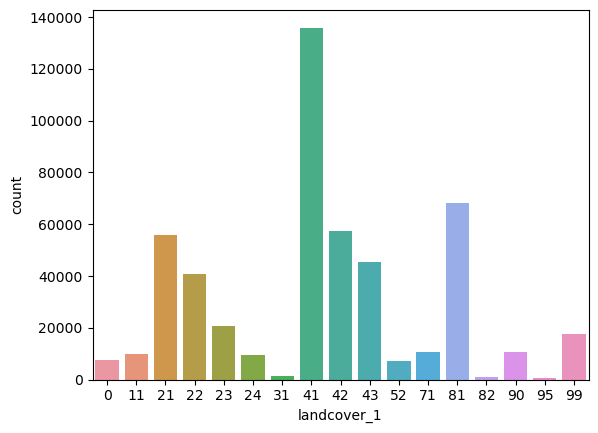

In [7]:
sns.countplot(x="landcover_1", data=dataframe)
plt.show()

# 4b. Print all unique values in the 'landcover_1' column

In [8]:
dataframe['landcover_1'].unique()

array([42, 41, 81, 21, 99, 24, 43, 23, 22, 11, 90,  0, 71, 52, 31, 82, 95])

## 5. Print a heatmap with correlations of the numerical variables

> __HINT__: You can check the assignment instructions for the code

>__HINT__: numerical values = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5',
       'landsat_6', 'dem_1', 'posidex_1', 
       'landcover_1']

<Axes: >

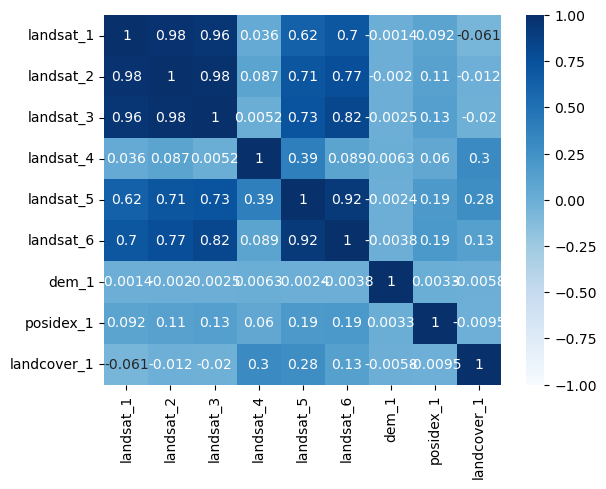

In [9]:
values = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1', 'posidex_1', 'landcover_1']
sns.heatmap(dataframe[values].corr(), annot=True, vmin=-1.0, vmax=1.0, cmap="Blues")

## 6. Define Processing Function
>__HINT__: create a python function take takes as input the path to your csv and returns a preprocessed dataframe following all the PROCESSING steps you completed in this assignment

>__HINT__: want to remove the invalid values and one-hot encode the categorical features and fill the missing/no-data values (what are the valid values for landcover_1 (remove any observations not in the valid range)

>__NOTE__: write out the functions you use a lot to a functions.py file that way you can import then from that file and not rewrite them in each new notebook

>__i.e__: from functions import one_hot_encode, regression_preprocess, binary_classification_preprocess

Write this function into the functions.py file and then import it into this notebook for use

In [10]:
from functions import one_hot_encode, multiclass_classification_preprocess

## 6a. Create new preprocessed dataframe using your processing function

In [11]:
processed = multiclass_classification_preprocess('s3://geokarma-testing/geoKARMA_h24v13_pixelbased_dataset.csv')

# Part 2. Training the Models

## 1. Label Encoding

> __NOTE__: NLCD class legend is as follows (see image below)

<img src="nlcd_landcover_legend.jpg" alt="Drawing" style="width: 300px;"/>

> We need to remap these values to be between 0-num_classes


In label encoding, each label is assigned a unique integer. This is based on alphabetical ordering. For example, if you were to encode Apple, Strawberry and Orange, Apple would be assigned the value 0, Orange: 1, and Strawberry: 2

you can use packaged solutions to this problem or create your own solution like below https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


In [12]:
label_encoding = {11: 0, 21: 1, 22: 2, 23: 3, 24: 4, 31: 5, 41: 6, 42: 7,
                  43: 8, 52: 9, 71: 10, 81: 11, 82: 12, 90: 13, 95: 14} 

def remap(value: int, encoding: dict) -> int:
    return encoding[value]

# Encode labels in column 'landcover_1'
processed['landcover_1'] = processed.apply(lambda x: remap(int(x['landcover_1']), label_encoding), axis=1)

## 2b. Print the unique values in "landcover_1"
After encoding, you should get these values as numbers and not categories.

In [13]:
processed['landcover_1'].unique()

array([ 7,  6, 11,  1,  4,  8,  3,  2,  0, 13, 10,  9,  5, 12, 14])

# 3. Feature Selection

#### 3a. Assign the target and feature variables
> Assign “landcover_1” as the target variable called __target__ and __features__ = ['landsat_{i}', 'dem_1', 'posidex_1', 'aspect_1_{i}', 'wetlands_1_{i}'] 

> __RECAP__: __Target variable__ is the dependent variable. That is, the variable whose value we want to predict.

> __Feature variable__ is the independent variable ie the variables which are used to predict the value of the dependent variable


Why can't we use impervious_1 as an input feature into the model? 

In [14]:
features = [
    'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1', 'posidex_1',
    'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4', 'aspect_1_5',
    'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 'aspect_1_10', 'aspect_1_11',
    'aspect_1_12', 'aspect_1_13', 'aspect_1_14', 'aspect_1_15', 'aspect_1_16',
    'aspect_1_17', 'aspect_1_18', 'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3',
    'wetlands_1_4', 'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8']
target = 'landcover_1'

## 4. Split data into train and test sets

> __RECAP__: The model is trained on the __train set__. It is used to fit the model.

> The __test set__ is used to evaluate the performance of the model.

In [15]:
X = processed[features]
y = processed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### 4a. Print dimensions of the train and test sets

In [16]:
print(X_train.shape)
print(X_test.shape)

(332465, 35)
(142485, 35)


#### 4b. Print the relative frequencies of the unique values in "y_train" and "y_test"
> __HINT__: You can find the code in the assignment instructions

In [17]:
print(f"The relative frequencies in y_train are:\n{y_train.value_counts(normalize=True)}" )
print(f"\nThe relative frequencies in y_train are:\n{y_test.value_counts(normalize=True)}")

The relative frequencies in y_train are:
landcover_1
6     0.286764
11    0.143793
7     0.120268
1     0.116800
8     0.095312
2     0.086018
3     0.043439
13    0.022842
10    0.022402
0     0.021301
4     0.020285
9     0.014949
5     0.003014
12    0.001714
14    0.001098
Name: proportion, dtype: float64

The relative frequencies in y_train are:
landcover_1
6     0.284956
11    0.143819
7     0.121564
1     0.118672
8     0.095210
2     0.084963
3     0.043977
10    0.022830
13    0.022753
0     0.020950
4     0.019644
9     0.014830
5     0.002948
12    0.001769
14    0.001116
Name: proportion, dtype: float64


# 5. Logistic Regression

#### 5a. Fit the logistic regression model

> Here, we are using the One vs Rest logistic regression classifier. In this, one classifier is fitted per class. For each classifier, the class is fitted against all the other classes.

> __HINT__: You can find the code in the assignment instructions

In [19]:
model = LogisticRegression(max_iter = 8000, multi_class='ovr', random_state = 1)
model = model.fit(X_train, y_train)

#### 5b. Predict class labels for samples in the test set and assign it to "te_pred"

> __HINT__: You can do this with model.predict. You can 

In [20]:
te_pred = model.predict(X_test)

#### 5c. Predict class labels for samples in the train set and assign it to "tr_pred"

In [21]:
tr_pred = model.predict(X_train)

#### 5d. Print accuracy for the train and test sets

In [22]:
accuracy_score(y_train, tr_pred).round(3)

0.5650000000000001

#### 5e. Print a classification report for the model
> __HINT__: You can check the assignment instructions for how to do this

In [23]:
print(classification_report(y_test, te_pred))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2985
           1       0.33      0.18      0.23     16909
           2       0.40      0.38      0.39     12106
           3       0.52      0.16      0.25      6266
           4       0.75      0.59      0.66      2799
           5       0.00      0.00      0.00       420
           6       0.59      0.89      0.71     40602
           7       0.55      0.63      0.59     17321
           8       0.28      0.01      0.03     13566
           9       0.00      0.00      0.00      2113
          10       0.39      0.01      0.02      3253
          11       0.58      0.83      0.68     20492
          12       0.00      0.00      0.00       252
          13       0.74      0.89      0.81      3242
          14       0.50      0.03      0.05       159

    accuracy                           0.56    142485
   macro avg       0.44      0.37      0.35    142485
weighted avg       0.50   

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6. Decision Tree

> A decision tree is a type of supervised machine learning used to categorize or make predictions based on the labelled data provided to it.

#### 6a. Fit a decision tree to the data

> __HINT__: You can check the document for the instructions

In [24]:
dt = DecisionTreeClassifier(max_depth=11, random_state = 1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, random_state=1)

#### 6b. Predict class labels for samples in the test set and assign it to "te_pred_dt"

In [25]:
te_pred_dt = dt.predict(X_test)

#### 6c. Predict class labels for samples in the train set and assign it to "tr_pred_dt"

In [26]:
tr_pred_dt = dt.predict(X_train)

#### 6d. Print the accuracy of the decision tree for the training and testing sets

In [27]:
print('accuracy for training set=', accuracy_score(y_train, tr_pred_dt).round(3))
print('accuracy for testing set=', accuracy_score(y_test, te_pred_dt).round(3))

accuracy for training set= 0.629
accuracy for testing set= 0.606


#### 6e. Print a classification report for the model

In [28]:
print(classification_report(y_test, te_pred_dt))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2985
           1       0.36      0.28      0.32     16909
           2       0.48      0.55      0.51     12106
           3       0.55      0.51      0.53      6266
           4       0.71      0.69      0.70      2799
           5       0.23      0.02      0.04       420
           6       0.67      0.82      0.74     40602
           7       0.66      0.67      0.66     17321
           8       0.43      0.18      0.26     13566
           9       0.29      0.04      0.07      2113
          10       0.39      0.09      0.15      3253
          11       0.63      0.81      0.70     20492
          12       0.00      0.00      0.00       252
          13       0.80      0.82      0.81      3242
          14       0.09      0.03      0.04       159

    accuracy                           0.61    142485
   macro avg       0.48      0.43      0.43    142485
weighted avg       0.58   

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
